In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import emcee

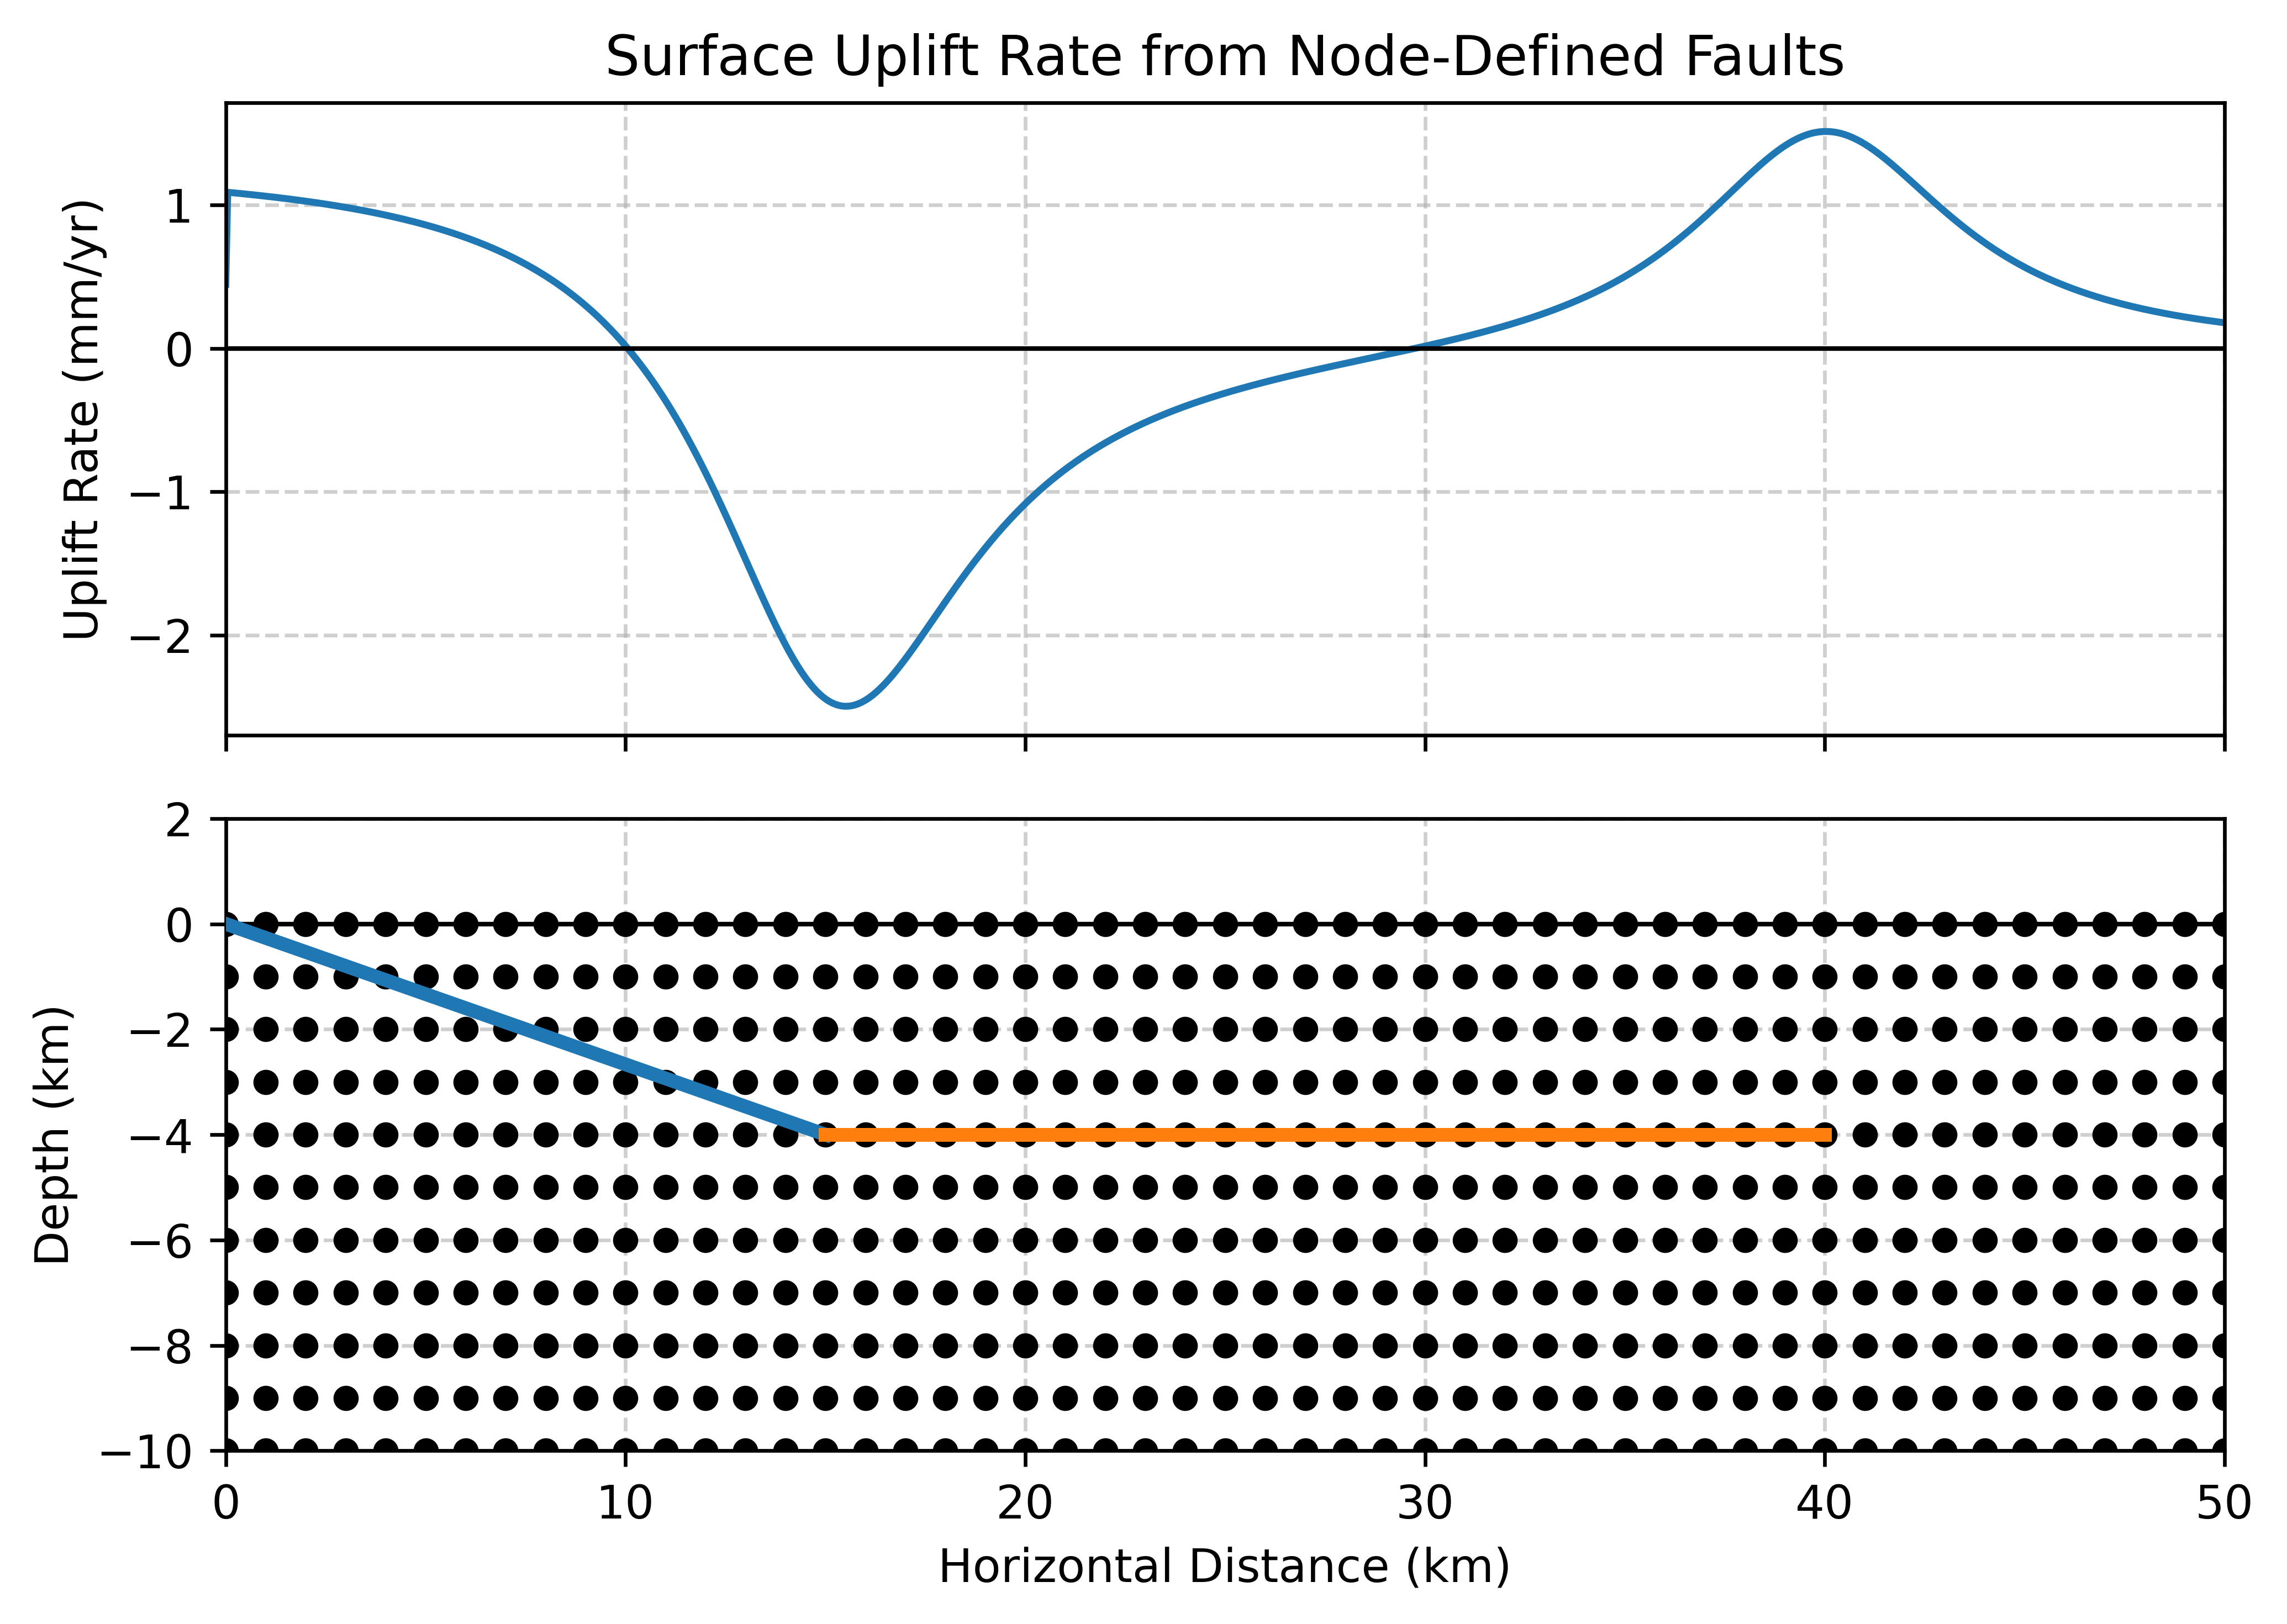

In [13]:
import numpy as np
import matplotlib.pyplot as plt

x_min, x_max = 0.0, 50.0
y_top, y_bot = 0.0, -10.0
dx_nodes, dy_nodes = 1.0, 1.0

x_nodes = np.arange(x_min, x_max + 0.1, dx_nodes)
y_nodes = np.arange(y_top, y_bot - 0.1, -dy_nodes)  

all_nodes = np.array([(xn, yn) for xn in x_nodes for yn in y_nodes]) 
num_nodes = len(all_nodes)
true_faults = [
    {'start': (0.0, 0.0),  'end': (15.0, -4.0), 's_rate': -0.005},
    {'start': (15.0, -4.0),  'end': (40.0, -4.0), 's_rate': 0.005},
]


x_obs = np.linspace(x_min, x_max, 1001)

def calculate_velocities_semi_infinite(x_obs, s_rate, delta, d_start, x_start):
    if d_start == 0:
        arcterm = np.arctan2((x_obs - x_start), 1e-12)
        v1 = (s_rate / np.pi) * (np.cos(delta) * arcterm)
        v2 = -(s_rate / np.pi) * (np.sin(delta) * arcterm)
    else:
        zeta = (x_obs - x_start) / d_start
        v1 = (s_rate / np.pi) * (np.cos(delta) * np.arctan(zeta) +
                                (np.sin(delta) - zeta * np.cos(delta)) / (1.0 + zeta**2))
        v2 = -(s_rate / np.pi) * (np.sin(delta) * np.arctan(zeta) +
                                 (np.cos(delta) + zeta * np.sin(delta)) / (1.0 + zeta**2))
    return v1, v2

node_set = {(xn, yn) for xn in x_nodes for yn in y_nodes}
for f in true_faults:
    if f['start'] not in node_set or f['end'] not in node_set:
        raise ValueError(f"Fault endpoints must be selected from node coordinates. Offending fault: {f}")

v1_total = np.zeros_like(x_obs)
v2_total = np.zeros_like(x_obs)

for f in true_faults:
    x1, z1 = f['start']
    x2, z2 = f['end']
    s_rate = f['s_rate']
    if s_rate == 0:
        continue
    d_top, d_bot = -z1, -z2
    x_top, x_bot = x1, x2
    delta = np.arctan2(-(z2 - z1), x2 - x1)
    v1_top, v2_top = calculate_velocities_semi_infinite(x_obs, s_rate, delta, d_top, x_top)
    v1_bot, v2_bot = calculate_velocities_semi_infinite(x_obs, -s_rate, delta, d_bot, x_bot)
    v1_total += (v1_top + v1_bot)
    v2_total += (v2_top + v2_bot)

fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(7, 5), sharex=True)

ax_top.set_xlim(x_min, x_max)
ax_top.plot(x_obs, v2_total * 1000, label="Vertical Uplift Rate")

x_obsa = x_obs
v2_totala = v2_total
ax_top.axhline(0, lw=1.0, color='black')
ax_top.set_ylabel("Uplift Rate (mm/yr)")
ax_top.set_title("Surface Uplift Rate from Node-Defined Faults")
ax_top.grid(True, linestyle='--', alpha=0.6)

ax_bot.axhline(0, lw=1.0, color='black')

for i, f in enumerate(true_faults):
    x1, z1 = f['start']
    x2, z2 = f['end']
    slip_rate_cm = f['s_rate'] * 100
    ax_bot.plot([x1, x2], [z1, z2], lw=3, label=f"Segment {i+1} (rate={slip_rate_cm:.1f} cm/yr)",zorder=10)

Xg, Yg = np.meshgrid(x_nodes, y_nodes)
ax_bot.scatter(Xg.flatten(), Yg.flatten(), s=20, c='k', zorder=3)

ax_bot.set_xlabel("Horizontal Distance (km)")
ax_bot.set_ylabel("Depth (km)")
ax_bot.set_xlim(x_min, x_max)
ax_bot.set_ylim(y_bot, 2)
ax_bot.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [14]:
def calculate_velocities_semi_infinite(x_obs, s_rate, delta, d_start, x_start):
    if d_start == 0:
        arcterm = np.arctan2((x_obs - x_start), 1e-12)
        v1 = (s_rate / np.pi) * (np.cos(delta) * arcterm)
        v2 = -(s_rate / np.pi) * (np.sin(delta) * arcterm)
    else:
        zeta = (x_obs - x_start) / d_start
        v1 = (s_rate / np.pi) * (np.cos(delta) * np.arctan(zeta) +
                                (np.sin(delta) - zeta * np.cos(delta)) / (1.0 + zeta**2))
        v2 = -(s_rate / np.pi) * (np.sin(delta) * np.arctan(zeta) +
                                 (np.cos(delta) + zeta * np.sin(delta)) / (1.0 + zeta**2))
    return v1, v2

v2_true = np.zeros_like(x_obs)
for fault in true_faults:
    x1_true, z1_true = fault['start']
    x2_true, z2_true = fault['end']
    s_rate_true = fault['s_rate']
    delta_true = np.arctan2(-(z2_true - z1_true), x2_true - x1_true)
    _, v2_true_top = calculate_velocities_semi_infinite(x_obs, s_rate_true, delta_true, -z1_true, x1_true)
    _, v2_true_bot = calculate_velocities_semi_infinite(x_obs, -s_rate_true, delta_true, -z2_true, x2_true)
    v2_true += (v2_true_top + v2_true_bot)

rng = np.random.default_rng(42)
sigma_mm = 0.5
sigma = sigma_mm / 1000.0
v2_noisy = v2_true + rng.normal(0.0, sigma, size=v2_true.shape)

n_faults_model = 3
ndim = (n_faults_model + 1) + n_faults_model

def log_prior(theta):
    node_indices = [int(np.round(i)) for i in theta[:n_faults_model + 1]]
    slip_rates = theta[n_faults_model + 1:]
    if not all(0 <= idx < num_nodes for idx in node_indices):
        return -np.inf
    if not all(-0.01 <= s_rate < 0 for s_rate in slip_rates):
        return -np.inf
    for i in range(n_faults_model):
        start_node = all_nodes[node_indices[i]]
        end_node = all_nodes[node_indices[i+1]]
        x1, z1 = start_node
        x2, z2 = end_node
        if not (x1 < x2 and z1 >= z2):
            return -np.inf
    return 0.0

def log_likelihood(theta, x_obs, data, yerr):
    node_indices = [int(np.round(i)) for i in theta[:n_faults_model + 1]]
    slip_rates = theta[n_faults_model + 1:]
    model_v2 = np.zeros_like(x_obs)
    for i in range(n_faults_model):
        start_node = all_nodes[node_indices[i]]
        end_node = all_nodes[node_indices[i+1]]
        s_rate = slip_rates[i]
        x1, z1 = start_node
        x2, z2 = end_node
        delta = np.arctan2(-(z2 - z1), x2 - x1)
        _, v2_top = calculate_velocities_semi_infinite(x_obs, s_rate, delta, -z1, x1)
        _, v2_bot = calculate_velocities_semi_infinite(x_obs, -s_rate, delta, -z2, x2)
        model_v2 += (v2_top + v2_bot)
    return -0.5 * np.sum(((data - model_v2) / yerr)**2)

def log_probability(theta, x_obs, data, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x_obs, data, yerr)

nwalkers = 1000
pos = np.zeros((nwalkers, ndim))
rng = np.random.default_rng()

print("Initializing walkers...")
for i in range(nwalkers):
    while True:
        try:
            node_indices = []
            start_idx = rng.choice(num_nodes)
            node_indices.append(start_idx)
            current_node_idx = start_idx
            for _ in range(n_faults_model):
                current_x, current_z = all_nodes[current_node_idx]
                valid_next_indices = [
                    idx for idx, (xn, zn) in enumerate(all_nodes)
                    if xn > current_x and zn <= current_z and idx not in node_indices
                ]
                if not valid_next_indices:
                    raise ValueError("No valid next node found; restarting.")
                next_node_idx = rng.choice(valid_next_indices)
                node_indices.append(next_node_idx)
                current_node_idx = next_node_idx
            slip_rates = rng.uniform(-0.01, 0, size=n_faults_model)
            pos[i] = np.concatenate([node_indices, slip_rates])
            break
        except ValueError:
            continue

print("Initialization complete. Starting MCMC...")
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x_obs, v2_noisy, sigma))
sampler.run_mcmc(pos, 5000, progress=True)
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)

print("\nMCMC sampling finished.")
print(f"Shape of the flattened samples: {flat_samples.shape}")

Initializing walkers...
Initialization complete. Starting MCMC...


100%|██████████| 5000/5000 [01:11<00:00, 70.26it/s]


MCMC sampling finished.
Shape of the flattened samples: (300000, 7)


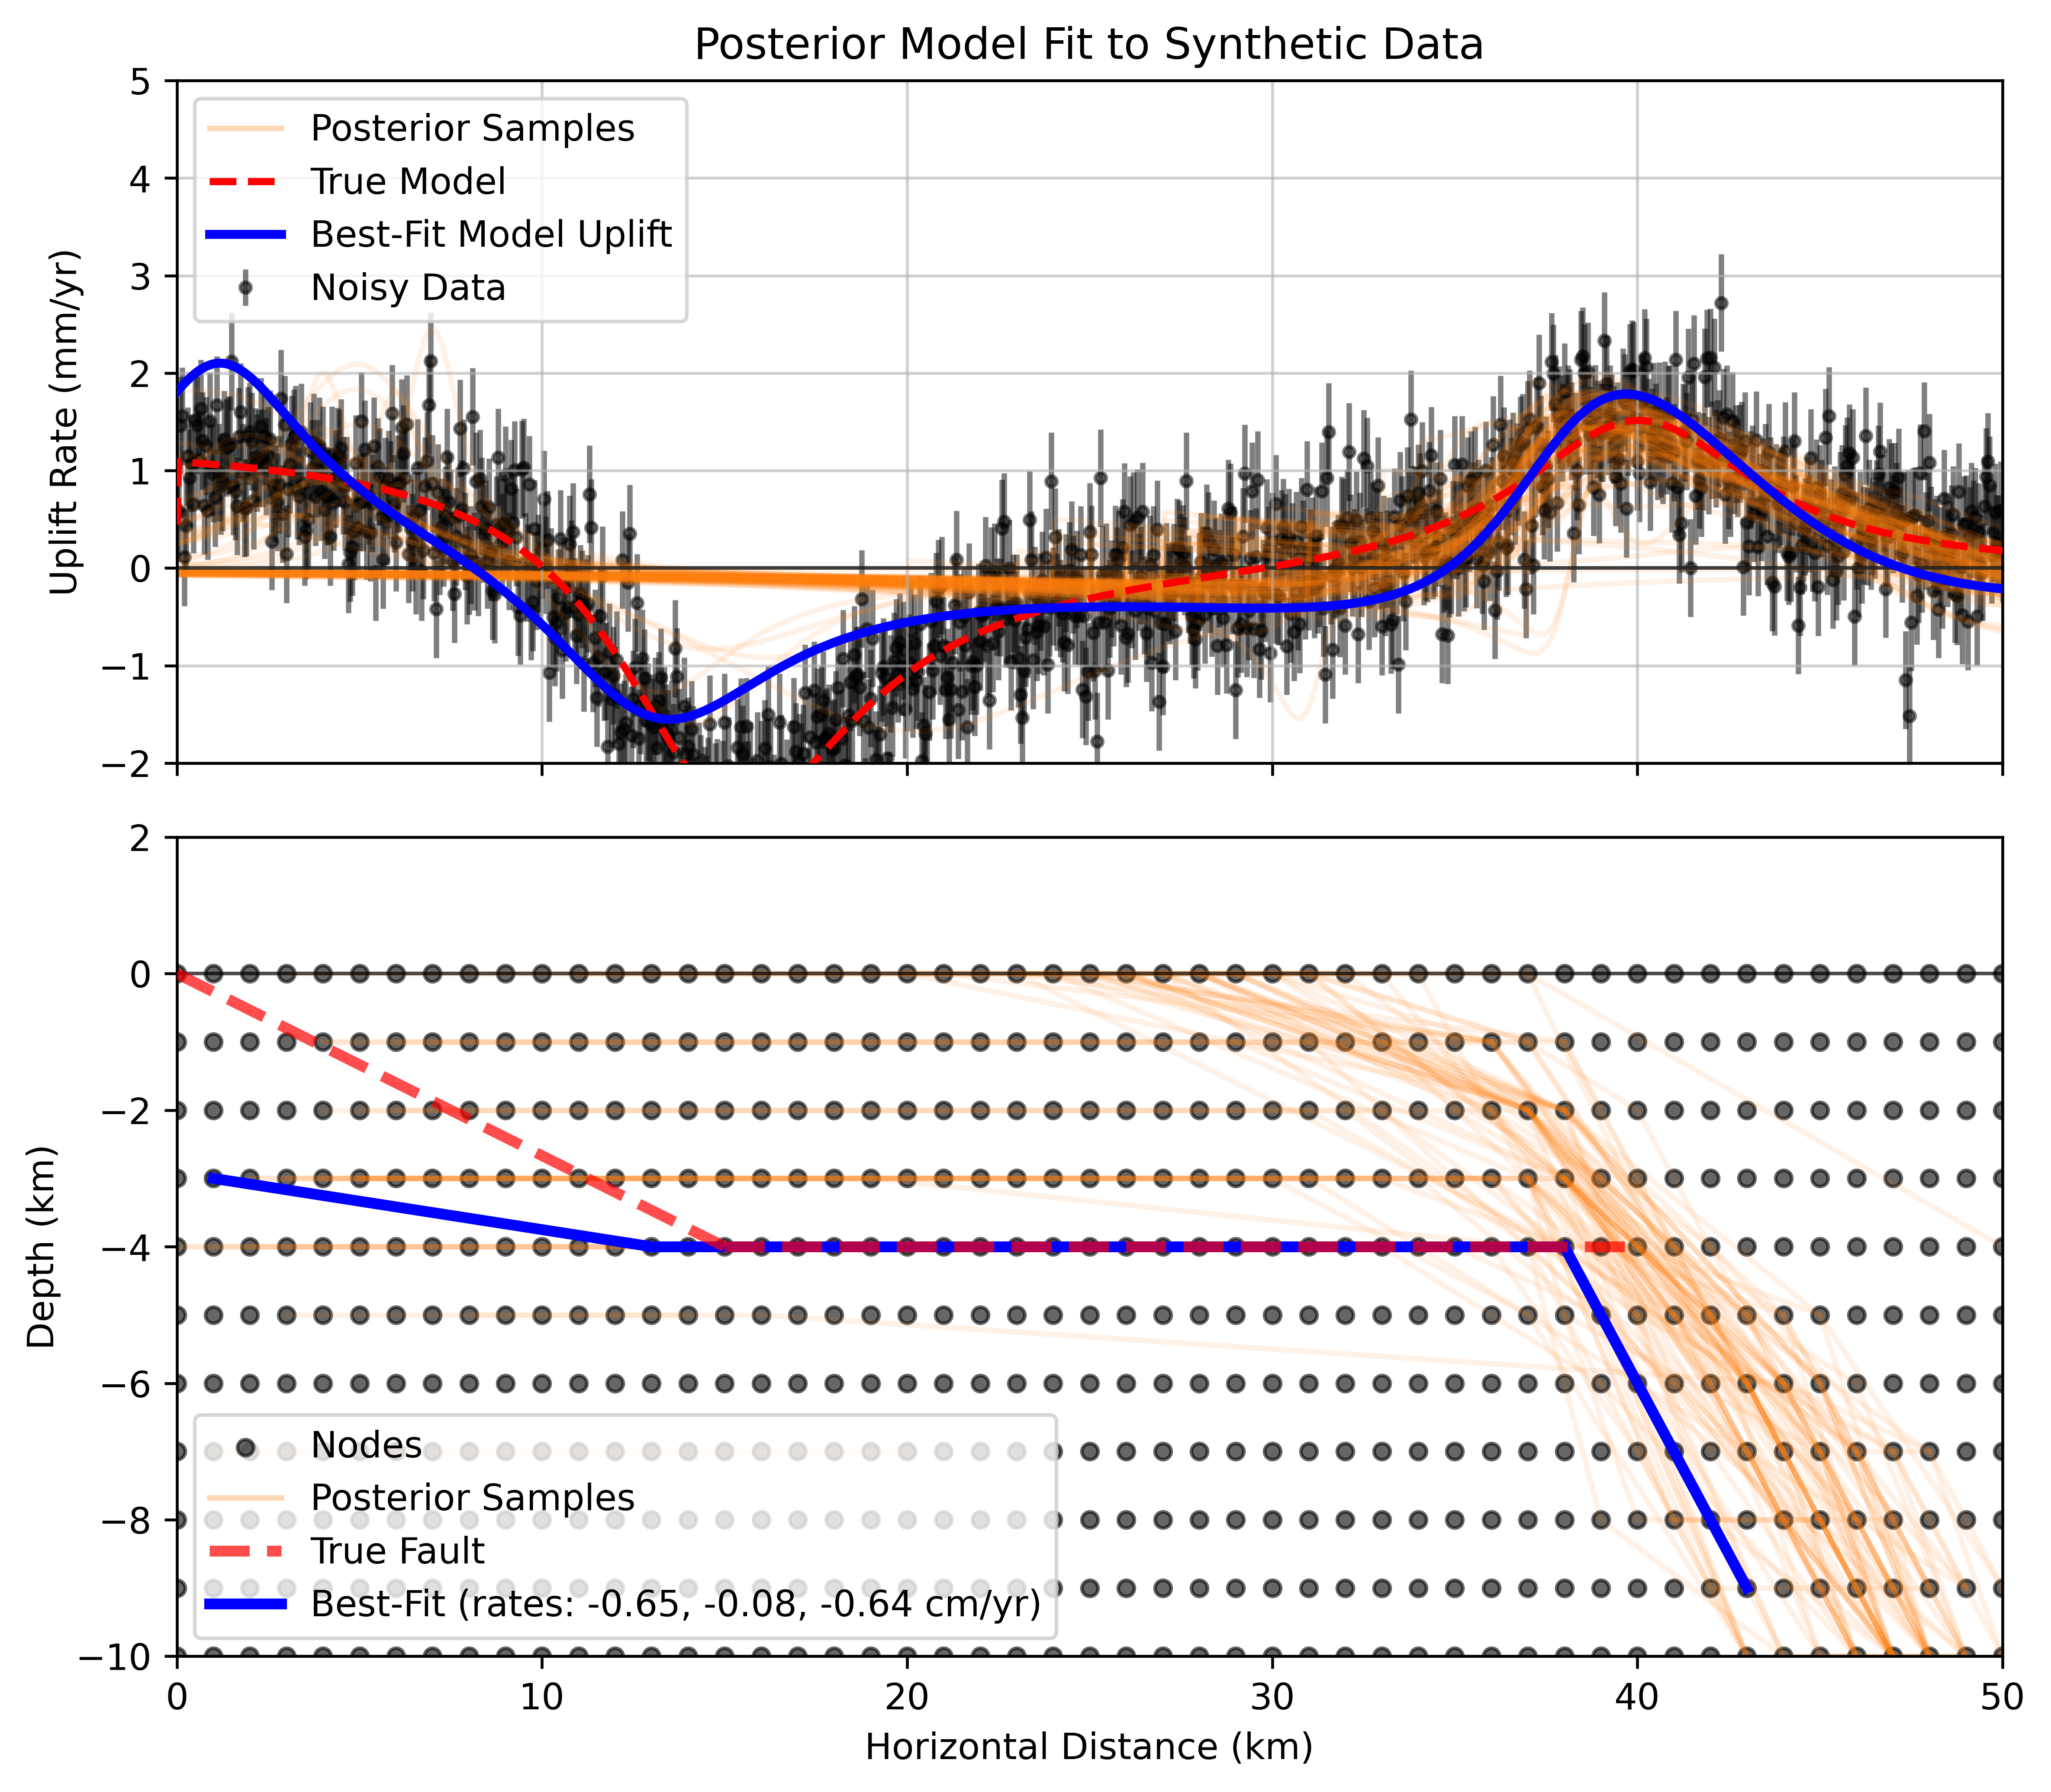

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Find the Argmax (Best-Fit / MAP) Model ---
log_prob_samples = sampler.get_log_prob(discard=1000, thin=15, flat=True)
best_fit_index = np.argmax(log_prob_samples)
best_fit_params = flat_samples[best_fit_index, :]

# Unpack the parameters for the best-fit multi-fault model
best_node_indices = [int(np.round(i)) for i in best_fit_params[:n_faults_model + 1]]
best_slip_rates = best_fit_params[n_faults_model + 1:]
best_nodes = [all_nodes[i] for i in best_node_indices]


# --- 2. Calculate the Uplift Rate for the Argmax Model ---
argmax_model_v2 = np.zeros_like(x_obs)
for i in range(n_faults_model):
    start_node = best_nodes[i]
    end_node = best_nodes[i+1]
    s_rate = best_slip_rates[i]
    
    x1, z1 = start_node
    x2, z2 = end_node
    
    delta = np.arctan2(-(z2 - z1), x2 - x1)
    _, v2_top = calculate_velocities_semi_infinite(x_obs, s_rate, delta, -z1, x1)
    _, v2_bot = calculate_velocities_semi_infinite(x_obs, -s_rate, delta, -z2, x2)
    argmax_model_v2 += (v2_top + v2_bot)


# --- 3. Create the Figure ---
fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(8, 7), sharex=True,
                                    gridspec_kw={'height_ratios': [1, 1.2]})
ax_top.set_xlim(x_min, x_max)


# --- 4. Plot Posterior Samples ---
size = 100
inds = np.arange(len(flat_samples) - size, len(flat_samples))
for ind in inds:
    try:
        sample = flat_samples[ind]
        node_indices_s = [int(np.round(i)) for i in sample[:n_faults_model + 1]]
        slip_rates_s = sample[n_faults_model + 1:]
        
        model_v2_s = np.zeros_like(x_obs)
        for i in range(n_faults_model):
            start_node_s = all_nodes[node_indices_s[i]]
            end_node_s = all_nodes[node_indices_s[i+1]]
            s_rate_s = slip_rates_s[i]
            x1_s, z1_s = start_node_s
            x2_s, z2_s = end_node_s
            delta_s = np.arctan2(-(z2_s - z1_s), x2_s - x1_s)
            _, v2_top_s = calculate_velocities_semi_infinite(x_obs, s_rate_s, delta_s, -z1_s, x1_s)
            _, v2_bot_s = calculate_velocities_semi_infinite(x_obs, -s_rate_s, delta_s, -z2_s, x2_s)
            model_v2_s += (v2_top_s + v2_bot_s)
        
        ax_top.plot(x_obs, model_v2_s * 1000, "C1", alpha=0.1, zorder=1)
        for i in range(n_faults_model):
            start_node_s = all_nodes[node_indices_s[i]]
            end_node_s = all_nodes[node_indices_s[i+1]]
            ax_bot.plot([start_node_s[0], end_node_s[0]], 
                        [start_node_s[1], end_node_s[1]], 
                        color="C1", alpha=0.1, zorder=2)
    except IndexError:
        continue


# --- 5. Finalize and Decorate Plots ---
ax_top.plot([], [], "C1", alpha=0.3, label='Posterior Samples', zorder=100)
ax_top.errorbar(x_obs, v2_noisy * 1000, yerr=sigma_mm, fmt=".", color='black', label="Noisy Data", zorder=0, alpha=0.5)
ax_top.plot(x_obs, v2_true * 1000, color='red', lw=2, linestyle='--', label="True Model", zorder=3)
ax_top.plot(x_obs, argmax_model_v2 * 1000, color='blue', lw=2.5, linestyle='-', label="Best-Fit Model Uplift", zorder=4)
ax_top.axhline(0, lw=1.0, color='black', alpha=0.7)
ax_top.set_ylabel("Uplift Rate (mm/yr)")
ax_top.set_ylim([-2, 5])
ax_top.set_title("Posterior Model Fit to Synthetic Data")
ax_top.legend()
ax_top.grid(True, linestyle='-', alpha=0.6)

ax_bot.axhline(0, lw=1.0, color='black', alpha=0.7)
Xg, Yg = np.meshgrid(x_nodes, y_nodes)
ax_bot.scatter(Xg.flatten(), Yg.flatten(), s=20, c='k', zorder=1, label='Nodes', alpha=0.6)
ax_bot.plot([], [], color="C1", alpha=0.3, label='Posterior Samples')

for i, fault in enumerate(true_faults):
    label = "True Fault" if i == 0 else ""
    ax_bot.plot([fault['start'][0], fault['end'][0]], 
                [fault['start'][1], fault['end'][1]], 
                color='red', lw=3, alpha=0.7, linestyle='--', label=label, zorder=100)

rate_str = ", ".join([f"{s*100:.2f}" for s in best_slip_rates])
best_fit_label = f"Best-Fit (rates: {rate_str} cm/yr)"
for i in range(n_faults_model):
    label = best_fit_label if i == 0 else ""
    start_node = best_nodes[i]
    end_node = best_nodes[i+1]
    ax_bot.plot([start_node[0], end_node[0]], 
                [start_node[1], end_node[1]], 
                color='blue', lw=3, label=label, zorder=4)

ax_bot.set_xlabel("Horizontal Distance (km)")
ax_bot.set_ylabel("Depth (km)")
ax_bot.set_ylim(y_bot, 2)
ax_bot.legend(loc="lower left")

plt.tight_layout()
plt.show()

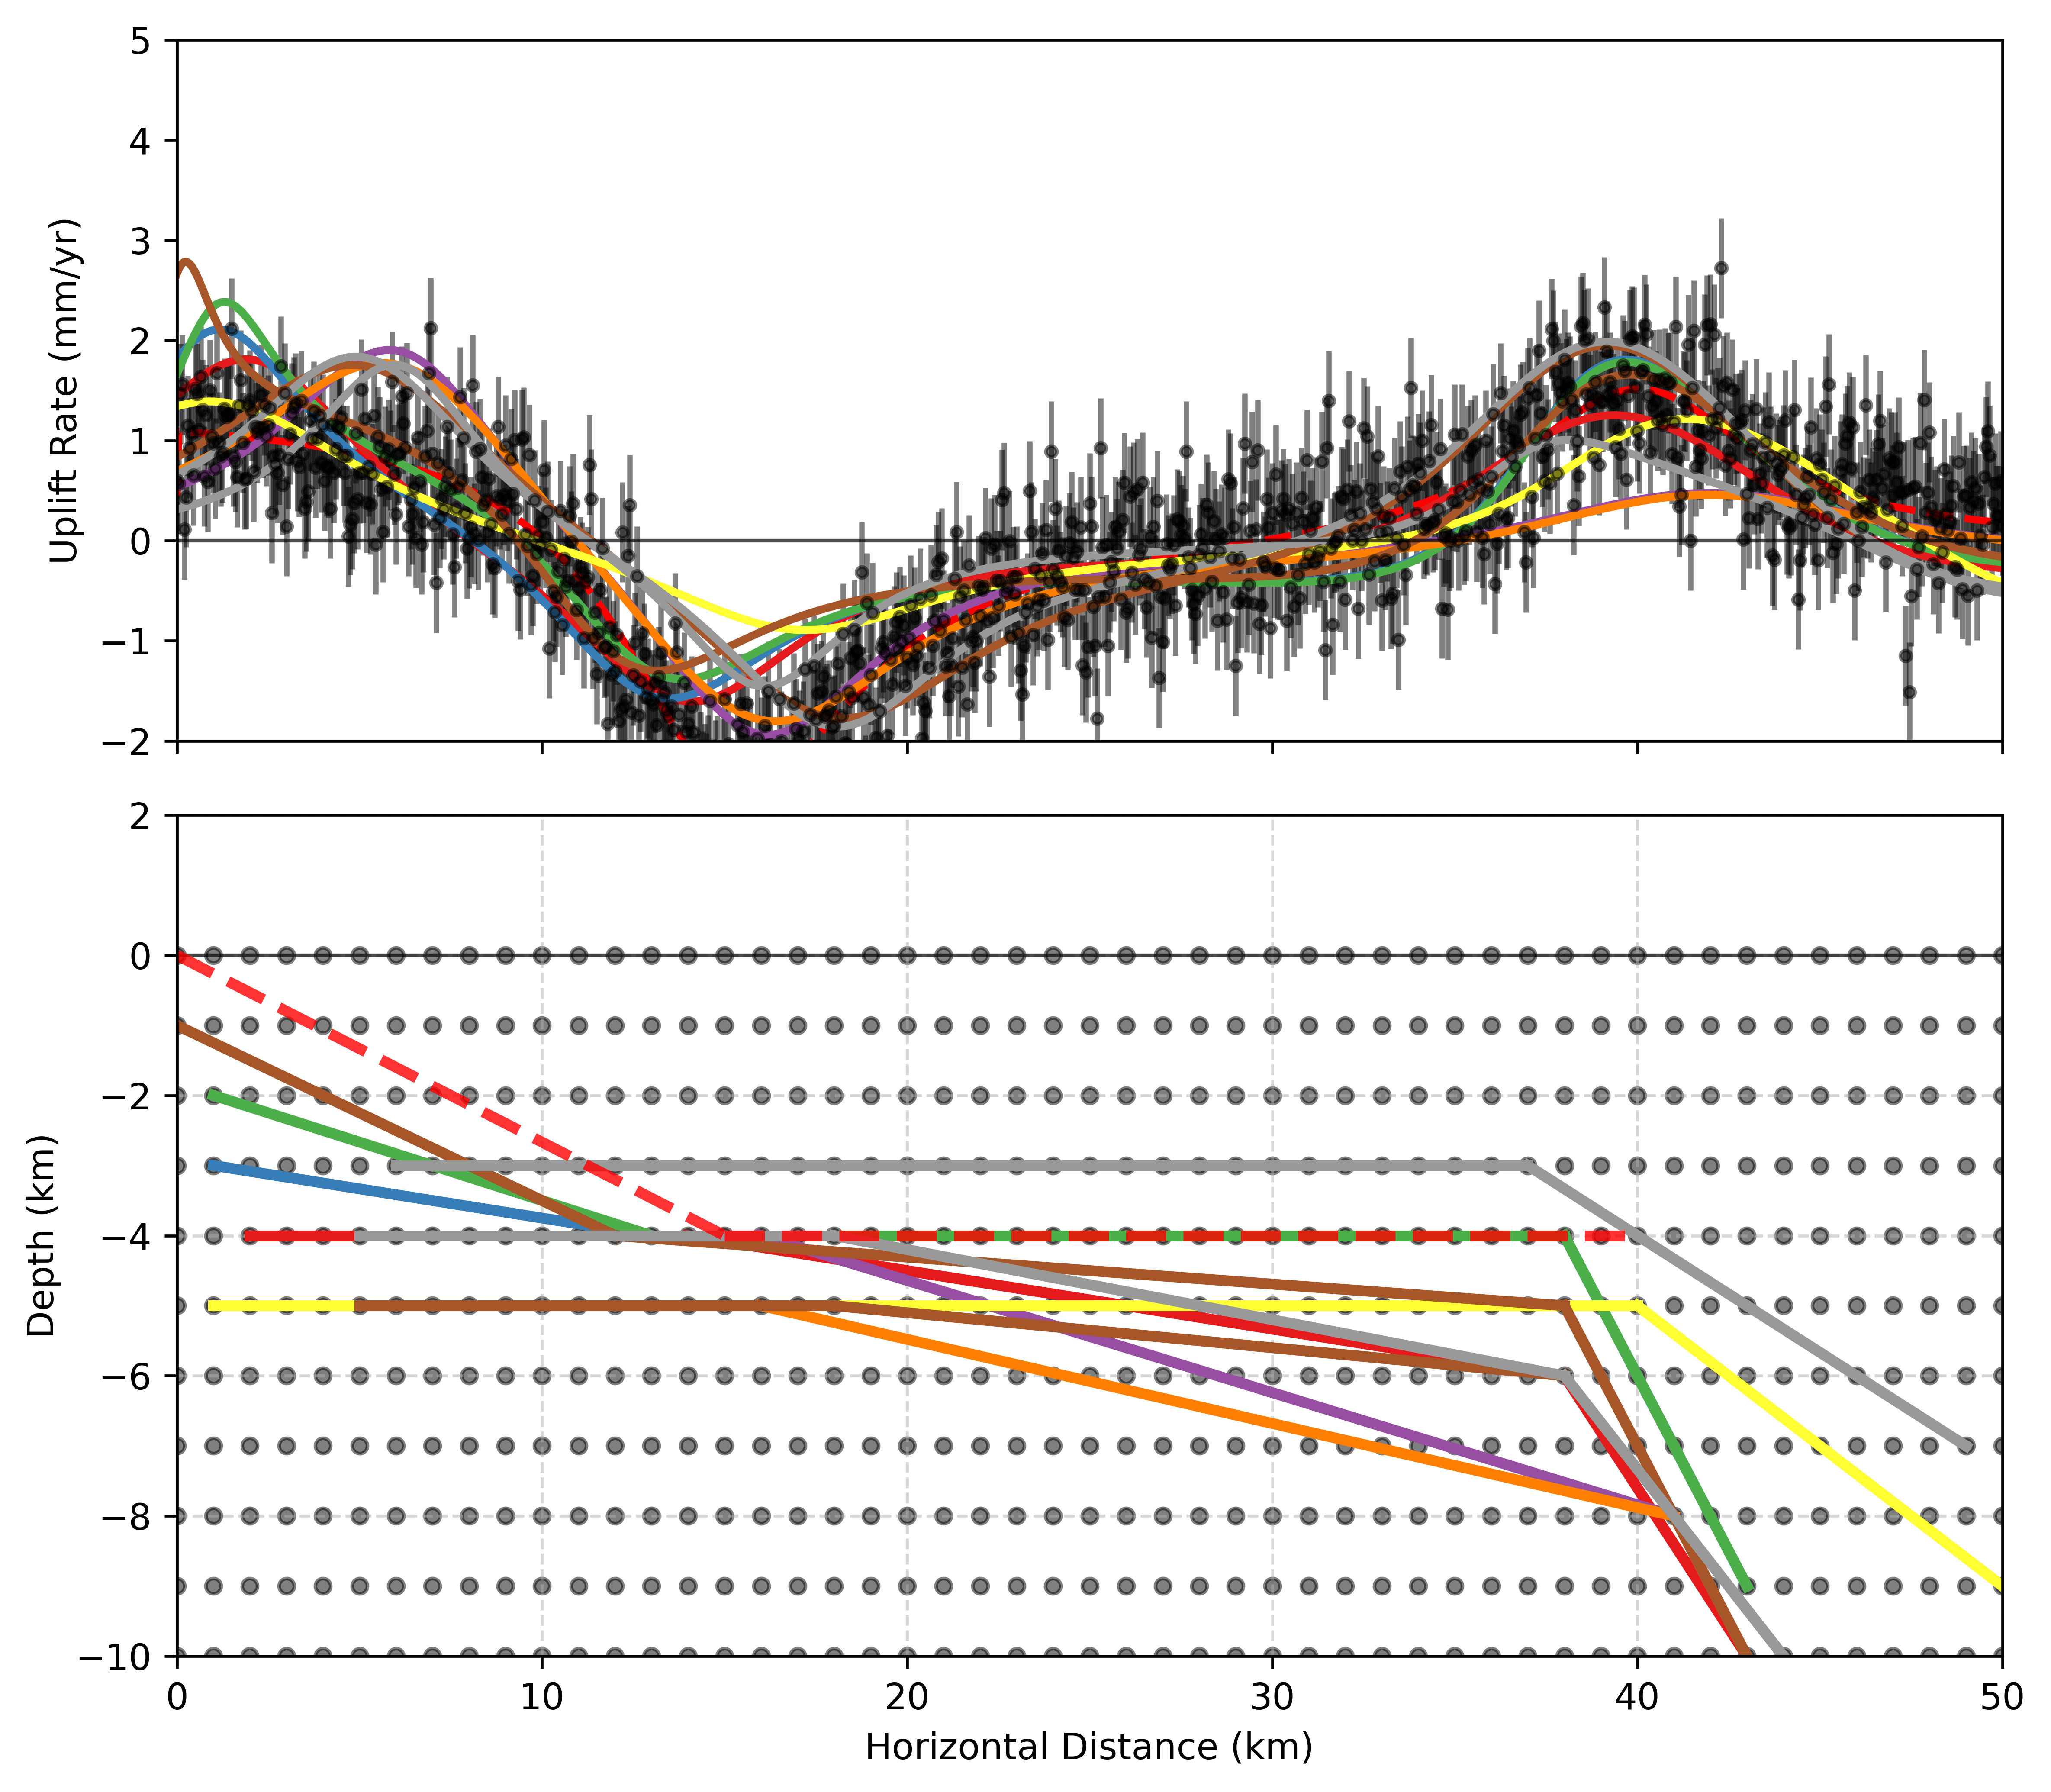

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

DISC = 1000
THIN = 15
flat_samples = sampler.get_chain(discard=DISC, thin=THIN, flat=True)
log_prob_samples = sampler.get_log_prob(discard=DISC, thin=THIN, flat=True)

def geometry_key_from_sample(sample, n_faults_model):
    idxs = [int(np.round(i)) for i in sample[:n_faults_model+1]]
    return tuple(idxs)

def geometry_is_valid(key, all_nodes):
    for i in range(len(key)-1):
        x1, z1 = all_nodes[key[i]]
        x2, z2 = all_nodes[key[i+1]]
        if not (x1 < x2 and z1 >= z2):
            return False
    return True

def v2_from_sample(sample, n_faults_model, all_nodes, x_obs):
    node_idx = [int(np.round(i)) for i in sample[:n_faults_model+1]]
    slips    = sample[n_faults_model+1:]
    v2 = np.zeros_like(x_obs)
    for i in range(n_faults_model):
        (x1,z1) = all_nodes[node_idx[i]]
        (x2,z2) = all_nodes[node_idx[i+1]]
        delta = np.arctan2(-(z2 - z1), x2 - x1)
        _, v2_top = calculate_velocities_semi_infinite(x_obs,  slips[i], delta, -z1, x1)
        _, v2_bot = calculate_velocities_semi_infinite(x_obs, -slips[i], delta, -z2, x2)
        v2 += v2_top + v2_bot
    return v2, node_idx, slips

groups = defaultdict(list)
for j, s in enumerate(flat_samples):
    key = geometry_key_from_sample(s, n_faults_model)
    if geometry_is_valid(key, all_nodes):
        groups[key].append(j)

if not groups:
    raise RuntimeError("No valid geometry groups found. Check rounding/priors.")

geom_ranking = []
for key, idxs in groups.items():
    best_idx_in_group = idxs[np.argmax(log_prob_samples[idxs])]
    best_lp = log_prob_samples[best_idx_in_group]
    geom_ranking.append((best_lp, key, best_idx_in_group, idxs))

geom_ranking.sort(reverse=True, key=lambda t: t[0]) 
TOP_K = 10
top_geoms = geom_ranking[:min(TOP_K, len(geom_ranking))]

representatives = []
for score, key, best_idx_in_group, idxs in top_geoms:
    rep_idx = best_idx_in_group
    reps = dict(key=key, rep_index=rep_idx, all_indices=idxs, score=score)
    representatives.append(reps)

fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(8, 7), sharex=True,
                                     gridspec_kw={'height_ratios': [1, 1.2]})
ax_top.set_xlim(x_min, x_max)

# data & truth
ax_top.errorbar(x_obs, v2_noisy*1000, yerr=sigma_mm, fmt=".", color='black', alpha=0.5, label="Noisy Data")
ax_top.plot(x_obs, v2_true*1000, color='red', lw=2, ls='--', label="True Model")

colors = plt.cm.Set1(np.linspace(0, 1, len(representatives)))

legend_labels = []
for c, rep in zip(colors, representatives):
    rep_sample = flat_samples[rep['rep_index']]
    v2_rep, node_idx, slips = v2_from_sample(rep_sample, n_faults_model, all_nodes, x_obs)

    # uplift curve
    ax_top.plot(x_obs, v2_rep*1000, color=c, lw=2.2,
                label=f"Mode rep (logP={rep['score']:.1f})")

    # geometry lines
    for i in range(n_faults_model):
        (x1, z1) = all_nodes[node_idx[i]]
        (x2, z2) = all_nodes[node_idx[i+1]]
        ax_bot.plot([x1, x2], [z1, z2], color=c, lw=3)

    # also print a compact label with slips
    slips_cm = ", ".join([f"{s*100:.2f}" for s in slips])
    legend_labels.append((c, node_idx, slips_cm))

# nodes & true faults
ax_bot.axhline(0, lw=1.0, color='black', alpha=0.7)
Xg, Yg = np.meshgrid(x_nodes, y_nodes)
ax_bot.scatter(Xg.flatten(), Yg.flatten(), s=18, c='k', alpha=0.5, edgecolors=None, label='Nodes')
for i, fault in enumerate(true_faults):
    lbl = "True Faults" if i == 0 else None
    ax_bot.plot([fault['start'][0], fault['end'][0]],
                [fault['start'][1], fault['end'][1]],
                color='red', lw=3, ls='--', alpha=0.8, label=lbl)

# decorate
ax_top.axhline(0, lw=1.0, color='black', alpha=0.7)
ax_top.set_ylabel("Uplift Rate (mm/yr)")
ax_top.set_ylim([-2, 5])
#ax_top.legend(loc="best")

ax_bot.set_xlabel("Horizontal Distance (km)")
ax_bot.set_ylabel("Depth (km)")
ax_bot.set_ylim(y_bot, 2)
#ax_bot.legend(loc="lower left")
ax_bot.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()